# MTH3302 - Méthodes probabilistes et statistiques pour I.A.
#### Polytechnique Montréal


### Projet A2024

-----

# Prédiction de la consommation en carburant de voitures récentes.

### Contexte

## TODO

### Objectif

## TODO

### Données
Les données utilisées pour inférer la consommation de carburant sont les suivantes :

## TODO


"annee";"type";"nombre_cylindres";"cylindree";"transmission";"boite";

#### pistes:

preprocessing:

quoi faire avec les variables fortement corrélees, cylindree et nombre cylindres (Supprimer une des deux, soit celle qui a le moins d'impact sur la consommation en carburant, ou les combiner en une seule variable) (ÉTAPE 1)
(si par exemple, on voit une augmentation disproportionnée de la consommation en carburant avec la cylindrée, on pourrait penser à les combiner en une seule variable)
Si nombre_cylindres est une quantité discrète et cylindree est une mesure continue (en litres), leur produit peut être vu comme une "capacité moteur totale", une métrique significative pour des modèles prédictifs.

nouvelle variable comme age du vehicule (2024 - year) (ca reduit l'importance de l'année dans les données) (Comparer avec juste l'enlever pour voir si ca ameliore le modele) (ÉTAPE 2)

reperer les outliers et les traiter

equilibrage des classes (sur ou sous representation des types de vehicules)

zscore normalization sur cylindree (ou nombre cylindres selon chat gpt mais pas certain)

ordinal encoding
one hot encoding (si peu de catégories) : Créez une colonne pour chaque catégorie.



In [1]:
using CSV, DataFrames, Statistics, Dates, Gadfly, Combinatorics, Plots, StatsBase, StatsPlots, Random, StatsModels, GLM, LinearAlgebra

In [14]:
full_train = CSV.read("../data/raw/train.csv", DataFrame; delim=";")
test =  CSV.read("../data/raw/test.csv", DataFrame; delim=";") #ne contient pas la varialbe consommation

Random.seed!(1234) #pour la reproductibilit

ntrain = round(Int, .8*nrow(full_train)) #80% des données pour l'entrainement: 80% * nb de lignes

train_id = sample(1:nrow(full_train), ntrain, replace=false, ordered=true) #échantillonnage aléatoire pour l'entrainement
valid_id = setdiff(1:nrow(full_train), train_id) #échantillon de validation. prend celles qui ne sont pas dans l'échantillon d'entrainement

train = full_train[train_id, :]  
valid = full_train[valid_id, :]


79×7 DataFrame
 Row │ annee  type                   nombre_cylindres  cylindree  transmission ⋯
     │ Int64  String31               Int64             String3    String15     ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │  2024  voiture_moyenne                       8  4,4        integrale    ⋯
   2 │  2024  voiture_sous_compacte                 6  3          propulsion
   3 │  2021  voiture_deux_places                   6  3          propulsion
   4 │  2018  voiture_compacte                      4  2          propulsion
   5 │  2015  VUS_standard                          8  6,2        4x4          ⋯
   6 │  2021  VUS_petit                             4  2          traction
   7 │  2018  voiture_sous_compacte                 4  2          integrale
   8 │  2014  VUS_standard                          8  4,8        integrale
  ⋮  │   ⋮              ⋮                   ⋮              ⋮           ⋮       ⋱
  73 │  2017  VUS_petit                             4  2,4        integrale    ⋯
  74 │  2019  voiture_deux_places                   8  6,2        propulsion
  75 │  2023  voiture_moyenne                       6  3,3        integrale
  76 │  2023  voiture_deux_places                   8  5          propulsion
  77 │  2024  voiture_deux_places                   8  5          integrale    ⋯
  78 │  2019  voiture_compacte                      6  3,5        integrale
  79 │  2022  voiture_compacte                      6  3,3        propulsion
                                                   2 columns and 64 rows omitted

## 1. Étude des données 

In [ ]:
training_stats = describe(train)
testing_stats = describe(test)
print("Training Set: \n", training_stats)
print("\n Testing Set: \n", testing_stats)

Training Set: 
7×7 DataFrame
 Row │ variable          mean     min               median  max                    nmissing  eltype   
     │ Symbol            Union…   Any               Union…  Any                    Int64     DataType 
─────┼────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ annee             2019.15  2014              2019.0  2024                          0  Int64
   2 │ type                       VUS_petit                 voiture_sous_compacte         0  String31
   3 │ nombre_cylindres  5.25237  3                 4.0     12                            0  Int64
   4 │ cylindree                  1,2                       6,4                           0  String3
   5 │ transmission               4x4                       traction                      0  String15
   6 │ boite                      automatique               manuelle                      0  String15
   7 │ consommation               10,2265217391304       

# 2. Exploration des données

## 2.1 Helpers

In [4]:
function safe_parse_int(x)
    try
        parse(Int, x)
    catch
        missing
    end
end

safe_parse_int (generic function with 1 method)

In [4]:
function safe_parse_float(x)
    try
        return parse(Float64, x)
    catch
        return missing
    end
end

safe_parse_float (generic function with 1 method)

In [ ]:
function one_hot_encode(df, cols, levels_dict)
    for col in cols
        levels_col = levels_dict[col]
        for level in levels_col
            new_col = Symbol(string(col) * "_" * string(level))
            df[!, new_col] = ifelse.(df[!, col] .== level, 1.0, 0.0)
        end
        # Remove the original column
        select!(df, Not(col))
    end
    return df
end

# 2.2 Analyse des données

In [1]:
data = deepcopy(train)
data = dropmissing(data)

UndefVarError: UndefVarError: `train` not defined

In [2]:
# Remplacer les virgules par des points
data.cylindree = replace.(data.cylindree, "," => ".")
data.consommation = replace.(data.consommation, "," => ".")

# Convertir 'cylindree' en Float64
data.cylindree = safe_parse_float.(data.cylindree)
data.consommation = safe_parse_float.(data.consommation)

UndefVarError: UndefVarError: `data` not defined

In [3]:
# Résumé des données
println(describe(data))

UndefVarError: UndefVarError: `describe` not defined

# Corrélation entre les variables

Matrice de corrélation :
[1.0 -0.2080829046196419 -0.22507170462114864 -0.21033424193286063; -0.2080829046196419 1.0 0.9459674028218671 0.8569696498409947; -0.22507170462114864 0.9459674028218671 1.0 0.85280334794806; -0.21033424193286063 0.8569696498409947 0.85280334794806 1.0]


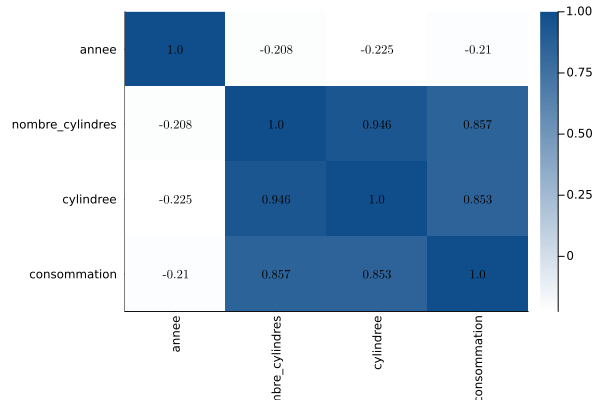

In [9]:
numeric_cols = [:annee, :nombre_cylindres, :cylindree, :consommation]

M = cor(Matrix(data[:, numeric_cols]))

# Afficher la matrice de corrélation
println("Matrice de corrélation :")
println(M)

# PLOT
(n,m) = size(M)
heatmap(M, fc=cgrad([:white,:dodgerblue4]), xticks=(1:m,numeric_cols), xrot=90, yticks=(1:m,numeric_cols), yflip=true)
annotate!([(j, i, text(round(M[i,j],digits=3), 8,"Computer Modern",:black)) for i in 1:n for j in 1:m])

1. `nombre_cylindres` et `cylindree` est très élevée, ce qui indique une forte relation positive. Cela suggère que le nombre de cylindres est fortement associé à la cylindrée des véhicules.

2. La corrélation entre `cylindree` et `consommation` est également élevée, montrant qu'une augmentation de la cylindrée est associée à une augmentation de la consommation (par exemple, les moteurs plus gros consomment plus de carburant).

3. Une corrélation similaire existe entre `nombre_cylindres` et `consommation`, ce qui est logique, car le nombre de cylindres et la cylindrée sont liés.

4. Les corrélations entre annee et les autres variables sont faibles et négatives, indiquant que les variables comme le nombre de cylindres, la cylindrée et la consommation ont légèrement diminué avec le temps.

## Consommation par type de véhicule

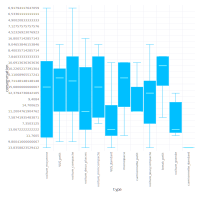

In [10]:
set_default_plot_size(20cm, 20cm)
Gadfly.plot(train, x=:type, y=:consommation, Geom.boxplot )

In [11]:
unique_categories = unique(skipmissing(data[:, :type]))
occurences = [sum(skipmissing(data[:, :type]) .== category) for category in unique_categories]
occurences = DataFrame(category = unique_categories, occurences = occurences)
occurences = occurences[occurences.occurences .> 10, :] #TODO INVESTIGATE 

7×2 DataFrame
 Row │ category               occurences 
     │ String31               Int64      
─────┼───────────────────────────────────
   1 │ voiture_moyenne                28
   2 │ VUS_petit                      86
   3 │ voiture_compacte               49
   4 │ voiture_deux_places            40
   5 │ voiture_minicompacte           17
   6 │ VUS_standard                   17
   7 │ voiture_sous_compacte          54

Consommation en fonction du type véhicule moyen :

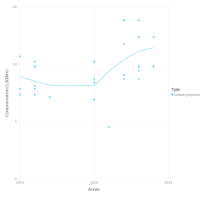

In [12]:
set_default_plot_size(20cm, 20cm)
vehicule_moyenne = filter(row -> row.type == "voiture_moyenne", data)
Gadfly.plot(vehicule_moyenne, x=:annee, y=:consommation, color=:type, Geom.point, Geom.smooth(method=:loess), Guide.xlabel("Année"), Guide.ylabel("Consommation (L/100km)"), Guide.colorkey("Type"))

Consommation en fonction du type VUS_petit

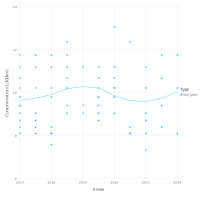

In [13]:
set_default_plot_size(20cm, 20cm)
vehicule_VUSp = filter(row -> row.type == "VUS_petit", data)
Gadfly.plot(vehicule_VUSp, x=:annee, y=:consommation, color=:type, Geom.point, Geom.smooth(method=:loess), Guide.xlabel("Année"), Guide.ylabel("Consommation (L/100km)"), Guide.colorkey("Type"))

Consommation en fonction du type véhicule compacte

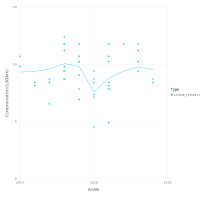

In [14]:
set_default_plot_size(20cm, 20cm)
voiture_compacte = filter(row -> row.type == "voiture_compacte", data)
Gadfly.plot(voiture_compacte, x=:annee, y=:consommation, color=:type, Geom.point, Geom.smooth(method=:loess), Guide.xlabel("Année"), Guide.ylabel("Consommation (L/100km)"), Guide.colorkey("Type"))

Consommation en fonction du type véhicule 2 places

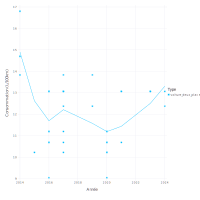

In [15]:
set_default_plot_size(20cm, 20cm)
voiture_deux_places = filter(row -> row.type == "voiture_deux_places", data)
Gadfly.plot(voiture_deux_places, x=:annee, y=:consommation, color=:type, Geom.point, Geom.smooth(method=:loess), Guide.xlabel("Année"), Guide.ylabel("Consommation (L/100km)"), Guide.colorkey("Type"))

Consommation en fonction du type véhicule camionnette standard

In [16]:
set_default_plot_size(20cm, 20cm)
camionnette_standard = filter(row -> row.type == "camionnette_standard", data)
Gadfly.plot(camionnette_standard, x=:annee, y=:consommation, color=:type, Geom.point, Geom.smooth(method=:loess), Guide.xlabel("Année"), Guide.ylabel("Consommation (L/100km)"), Guide.colorkey("Type"))

Plot(...)

Consommation en fonction du type véhicule mini compacte

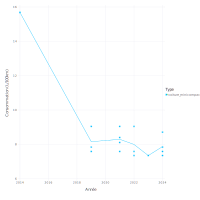

In [17]:
set_default_plot_size(20cm, 20cm)
voiture_minicompacte = filter(row -> row.type == "voiture_minicompacte", data)
Gadfly.plot(voiture_minicompacte, x=:annee, y=:consommation, color=:type, Geom.point, Geom.smooth(method=:loess), Guide.xlabel("Année"), Guide.ylabel("Consommation (L/100km)"), Guide.colorkey("Type"))

Consommation en fonction du type véhicule VUS standard

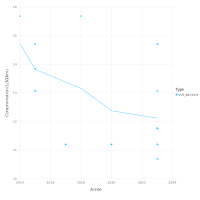

In [18]:
set_default_plot_size(20cm, 20cm)
VUS_standard = filter(row -> row.type == "VUS_standard", data)
Gadfly.plot(VUS_standard, x=:annee, y=:consommation, color=:type, Geom.point, Geom.smooth(method=:loess), Guide.xlabel("Année"), Guide.ylabel("Consommation (L/100km)"), Guide.colorkey("Type"))

Consommation en fonction du type véhicule sous-compacte

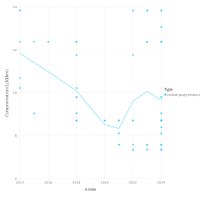

In [19]:
set_default_plot_size(20cm, 20cm)
voiture_sous_compacte = filter(row -> row.type == "voiture_sous_compacte", data)
Gadfly.plot(voiture_sous_compacte, x=:annee, y=:consommation, color=:type, Geom.point, Geom.smooth(method=:loess), Guide.xlabel("Année"), Guide.ylabel("Consommation (L/100km)"), Guide.colorkey("Type"))

## Consommation par cylindrée

## Consommation par nombre de cylindres

## Consommation par année //TODO METTRE UNE NOTE COMME QUOI PAS BESOIN D'INVESTIGUER

# 3. Régression linéaire

In [545]:
Random.seed!(1234) #pour la reproductibilité

ntrain = round(Int, .8*nrow(full_train)) #80% des données pour l'entrainement: 80% * nb de lignes

train_id = sample(1:nrow(full_train), ntrain, replace=false, ordered=true) #échantillonnage aléatoire pour l'entrainement
valid_id = setdiff(1:nrow(full_train), train_id) #échantillon de validation. prend celles qui ne sont pas dans l'échantillon d'entrainement

train = full_train[train_id, :]  
valid = full_train[valid_id, :]

first(train, 5)

5×7 DataFrame
 Row │ annee  type                 nombre_cylindres  cylindree  transmission   ⋯
     │ Int64  String31             Int64             String3    String15       ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │  2023  voiture_moyenne                     8  4,4        integrale      ⋯
   2 │  2020  VUS_petit                           4  2          integrale
   3 │  2021  voiture_compacte                    6  3,3        propulsion
   4 │  2023  voiture_deux_places                 8  5          integrale
   5 │  2022  voiture_moyenne                     8  4,4        integrale      ⋯
                                                               2 columns omitted

In [508]:
# Remplacer les virgules par des points
train.cylindree = replace.(train.cylindree, "," => ".")
valid.cylindree = replace.(valid.cylindree, "," => ".")
train.consommation = replace.(train.consommation, "," => ".")
valid.consommation = replace.(valid.consommation, "," => ".")

# Convertir 'cylindree' en Float64
train.cylindree = safe_parse_float.(train.cylindree)
valid.cylindree = safe_parse_float.(valid.cylindree)
train.consommation = safe_parse_float.(train.consommation)
valid.consommation = safe_parse_float.(valid.consommation)

79-element Vector{Float64}:
 12.3794736842105
  9.80041666666667
 10.6913636363636
  9.4084
 14.700625
  7.58741935483871
  8.71148148148148
 13.8358823529412
 12.3794736842105
 12.3794736842105
  ⋮
  8.71148148148148
  7.58741935483871
 10.2265217391304
 15.6806666666667
 11.7605
 12.3794736842105
 13.0672222222222
 10.2265217391304
 11.2004761904762

In [497]:
println(describe(train))

7×7 DataFrame
 Row │ variable          mean     min          median   max                    nmissing  eltype   
     │ Symbol            Union…   Any          Union…   Any                    Int64     DataType 
─────┼────────────────────────────────────────────────────────────────────────────────────────────
   1 │ annee             2019.15  2014         2019.0   2024                          0  Int64
   2 │ type                       VUS_petit             voiture_sous_compacte         0  String31
   3 │ nombre_cylindres  5.25237  3            4.0      12                            0  Int64
   4 │ cylindree         2.86467  1.2          2.5      6.4                           0  Float64
   5 │ transmission               4x4                   traction                      0  String15
   6 │ boite                      automatique           manuelle                      0  String15
   7 │ consommation      10.2898  4.52327      10.2265  16.8007                       0  Float64


In [ ]:
#drop type, numbre cylindre, cylindree,
# train = select(train, Not([:type, :transmission, :boite]))
# valid = select(valid,  Not([:type, :transmission, :boite]))


79×4 DataFrame
 Row │ annee  nombre_cylindres  cylindree  consommation 
     │ Int64  Int64             Float64    Float64      
─────┼──────────────────────────────────────────────────
   1 │  2024                 8        4.4      12.3795
   2 │  2024                 6        3.0       9.80042
   3 │  2021                 6        3.0      10.6914
   4 │  2018                 4        2.0       9.4084
   5 │  2015                 8        6.2      14.7006
   6 │  2021                 4        2.0       7.58742
   7 │  2018                 4        2.0       8.71148
   8 │  2014                 8        4.8      13.8359
  ⋮  │   ⋮           ⋮              ⋮           ⋮
  73 │  2017                 4        2.4      10.2265
  74 │  2019                 8        6.2      15.6807
  75 │  2023                 6        3.3      11.7605
  76 │  2023                 8        5.0      12.3795
  77 │  2024                 8        5.0      13.0672
  78 │  2019                 6        3.5      10.2265
  79 │  2022                 6        3.3      11.2005
                                         64 rows omitted

In [546]:
# Datasets that contain 'consommation'
datasets_with_consommation = [train, valid]

# Datasets without 'consommation'
datasets_without_consommation = [test]

# Apply replacements to 'cylindree' in all datasets
for df in [train, valid, test]
    df.cylindree = replace.(df.cylindree, "," => ".")
end

# Apply replacements to 'consommation' only in datasets that have it
for df in datasets_with_consommation
    df.consommation = replace.(df.consommation, "," => ".")
end

# Convert 'cylindree' to float in all datasets
for df in [train, valid, test]
    df.cylindree = safe_parse_float.(df.cylindree)
end

# Convert 'consommation' to float in datasets with 'consommation'
for df in datasets_with_consommation
    df.consommation = safe_parse_float.(df.consommation)
end

# Drop missing values in all datasets
for df in [train, valid, test]
    dropmissing!(df)
end

# Encode 'boite' column in all datasets
for df in [train, valid, test]
    df.boite = ifelse.(df.boite .== "automatique", 1.0, 0.0)
end

# One-hot encode categorical columns in all datasets
categorical_cols = [:type, :transmission]
for i in 1:length([train, valid, test])
    df = [train, valid, test][i]
    df = one_hot_encode(df, categorical_cols)
    # Update the dataset after encoding
    if i == 1
        train = df
    elseif i == 2
        valid = df
    else
        test = df
    end
end

In [519]:
describe(train)

21×7 DataFrame
 Row │ variable                    mean           min         median     max   ⋯
     │ Symbol                      Float64        Real        Float64    Real  ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ annee                       2019.15        2014        2019.0     2024  ⋯
   2 │ nombre_cylindres               5.25237        3           4.0       12
   3 │ cylindree                      2.86467        1.2         2.5        6.
   4 │ boite                          0.845426       0.0         1.0        1.
   5 │ consommation                  10.2898         4.52327    10.2265    16. ⋯
   6 │ type_voiture_moyenne           0.0883281      0.0         0.0        1.
   7 │ type_VUS_petit                 0.271293       0.0         0.0        1.
   8 │ type_voiture_compacte          0.154574       0.0         0.0        1.
  ⋮  │             ⋮                     ⋮            ⋮           ⋮          ⋮ ⋱
  15 │ type_break_petit               0.0252366      0.0         0.0        1. ⋯
  16 │ type_voiture_grande            0.022082       0.0         0.0        1.
  17 │ type_camionnette_standard      0.00630915     0.0         0.0        1.
  18 │ transmission_integrale         0.397476       0.0         0.0        1.
  19 │ transmission_propulsion        0.198738       0.0         0.0        1. ⋯
  20 │ transmission_traction          0.347003       0.0         0.0        1.
  21 │ transmission_4x4               0.0567823      0.0         0.0        1.
                                                    3 columns and 6 rows omitted

In [547]:
model = GLM.lm(@formula(consommation ~ annee + transmission_integrale + transmission_propulsion + transmission_traction + transmission_4x4 + nombre_cylindres + cylindree + boite), train)
# Prediction avec l'ensemble de validation
valid_prediction = GLM.predict(model, valid)
# Trouver la moyenne de prediction
mean_prediction = mean(valid_prediction)
# Remplacer les missing par la moyenne
valid_prediction = coalesce.(valid_prediction, mean_prediction)
# Transformer les predictions en valeur entiere
#v = Int.(round.(valid_prediction, digits=0)) #mettre une commentaire sur la difference que ca entraine sur le rmse
# Calculer le RMSE
rmse = sqrt(mean((valid_prediction - valid.consommation).^2))
println("RMSE: ", rmse)

RMSE: 0.9463139121914049


In [549]:
n = nrow(test)

id = 1:n

ŷ = GLM.predict(model, test)

df_pred = DataFrame(id=id, consommation=ŷ)

CSV.write("../submissions/linear/test_with_pred.csv", df_pred)

"../submissions/linear/test_with_pred.csv"

# 4. Régression bayesienne

In [119]:
# Datasets that contain 'consommation'
datasets_with_consommation = [train, valid]

# Datasets without 'consommation'
datasets_without_consommation = [test]

# Apply replacements to 'cylindree' in all datasets
for df in [train, valid, test]
    df.cylindree = replace.(df.cylindree, "," => ".")
end

# Apply replacements to 'consommation' only in datasets that have it
for df in datasets_with_consommation
    df.consommation = replace.(df.consommation, "," => ".")
end

# Convert 'cylindree' to float in all datasets
for df in [train, valid, test]
    df.cylindree = safe_parse_float.(df.cylindree)
end

# Convert 'consommation' to float in datasets with 'consommation'
for df in datasets_with_consommation
    df.consommation = safe_parse_float.(df.consommation)
end

# Drop missing values in all datasets
for df in [train, valid, test]
    dropmissing!(df)
end

# Encode 'boite' column in all datasets
for df in [train, valid, test]
    df.boite = ifelse.(df.boite .== "automatique", 1.0, 0.0)
end

# # Apply one-hot encoding to both train and valid
# categorical_cols = [:type, :transmission]
# for df in [train, valid, test]
#     df = one_hot_encode(df, categorical_cols)
#     df.boite = ifelse.(df.boite .== "automatique", 0.0, 1.0)
# end


In [121]:
# Define categorical columns
categorical_cols = [:type, :transmission, :boite]

# Collect unique levels from the training set
levels_dict = Dict()
for col in categorical_cols
    levels_dict[col] = unique(train[!, col])
end

In [122]:
# Apply one-hot encoding using the levels from the training set
train = one_hot_encode(train, categorical_cols, levels_dict)
valid = one_hot_encode(valid, categorical_cols, levels_dict)
test = one_hot_encode(test, categorical_cols, levels_dict)

# # Convert 'boite' variable in all datasets
# train.boite = ifelse.(train.boite .== "automatique", 0.0, 1.0)
# valid.boite = ifelse.(valid.boite .== "automatique", 0.0, 1.0)
# test.boite = ifelse.(test.boite .== "automatique", 0.0, 1.0)

150×21 DataFrame
 Row │ annee  nombre_cylindres  cylindree  type_voiture_moyenne  type_VUS_peti ⋯
     │ Int64  Int64             Float64    Float64               Float64       ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │  2014                 4        2.5                   1.0             0. ⋯
   2 │  2014                 4        2.5                   1.0             0.
   3 │  2014                 4        2.5                   0.0             1.
   4 │  2014                 4        2.0                   0.0             1.
   5 │  2014                 8        5.8                   0.0             0. ⋯
   6 │  2014                 8        5.0                   0.0             0.
   7 │  2014                 8        5.0                   0.0             0.
   8 │  2014                 4        2.4                   0.0             1.
  ⋮  │   ⋮           ⋮              ⋮               ⋮                  ⋮       ⋱
 144 │  2024                 4        1.6                   0.0             1. ⋯
 145 │  2024                 4        2.0                   0.0             0.
 146 │  2024                 4        2.0                   0.0             0.
 147 │  2024                 6        3.0                   0.0             0.
 148 │  2024                 6        3.0                   0.0             0. ⋯
 149 │  2024                 3        1.5                   0.0             0.
 150 │  2024                 4        2.0                   0.0             0.
                                                 17 columns and 135 rows omitted

In [123]:
y_train = train.consommation
X_train = select(train, Not(:consommation))
y_valid = valid.consommation
X_valid = select(valid, Not(:consommation))
X_test = deepcopy(test)


150×21 DataFrame
 Row │ annee  nombre_cylindres  cylindree  type_voiture_moyenne  type_VUS_peti ⋯
     │ Int64  Int64             Float64    Float64               Float64       ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │  2014                 4        2.5                   1.0             0. ⋯
   2 │  2014                 4        2.5                   1.0             0.
   3 │  2014                 4        2.5                   0.0             1.
   4 │  2014                 4        2.0                   0.0             1.
   5 │  2014                 8        5.8                   0.0             0. ⋯
   6 │  2014                 8        5.0                   0.0             0.
   7 │  2014                 8        5.0                   0.0             0.
   8 │  2014                 4        2.4                   0.0             1.
  ⋮  │   ⋮           ⋮              ⋮               ⋮                  ⋮       ⋱
 144 │  2024                 4        1.6                   0.0             1. ⋯
 145 │  2024                 4        2.0                   0.0             0.
 146 │  2024                 4        2.0                   0.0             0.
 147 │  2024                 6        3.0                   0.0             0.
 148 │  2024                 6        3.0                   0.0             0. ⋯
 149 │  2024                 3        1.5                   0.0             0.
 150 │  2024                 4        2.0                   0.0             0.
                                                 17 columns and 135 rows omitted

In [124]:
# Identify numeric feature indices
feature_names = names(train)
numeric_features = [ :cylindree, :nombre_cylindres, :annee]
numeric_indices = findall(x -> x in numeric_features, feature_names)

means = mean(Matrix(X_train[:, numeric_features]), dims=1)
stds = std(Matrix(X_train[:, numeric_features]), dims=1)

1×3 Matrix{Float64}:
 1.18853  1.77162  3.19217

In [125]:
function standardizer(X, means, stds)
    X = deepcopy(X)
    for j in 1:size(X, 2)
        if j in numeric_indices
            X[:, j] = (X[:, j] .- means[j]) ./ stds[j]
        end
    end
    return X
end

standardizer (generic function with 1 method)

In [126]:
X_train = standardizer(Matrix(X_train), means, stds)
X_valid = standardizer(Matrix(X_valid), means, stds)
X_test = standardizer(Matrix(X_test), means, stds)

y_train = Vector(y_train)
y_valid = Vector(y_valid)

79-element Vector{Float64}:
 12.3794736842105
  9.80041666666667
 10.6913636363636
  9.4084
 14.700625
  7.58741935483871
  8.71148148148148
 13.8358823529412
 12.3794736842105
 12.3794736842105
  ⋮
  8.71148148148148
  7.58741935483871
 10.2265217391304
 15.6806666666667
 11.7605
 12.3794736842105
 13.0672222222222
 10.2265217391304
 11.2004761904762

In [127]:
# Ridge regression with cross-validation
XtX = X_train' * X_train
Xty = X_train' * y_train
n_features = size(X_train, 2)

21

In [128]:
describe(valid)

22×7 DataFrame
 Row │ variable                    mean          min         median     max    ⋯
     │ Symbol                      Float64       Real        Float64    Real   ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ annee                       2019.38       2014        2019.0     2024   ⋯
   2 │ nombre_cylindres               5.41772       3           6.0        8
   3 │ cylindree                      3.05696       1.4         3.0        6.8
   4 │ consommation                  10.6257        6.35703    10.6914    16.8
   5 │ type_voiture_moyenne           0.126582      0.0         0.0        1.0 ⋯
   6 │ type_VUS_petit                 0.303797      0.0         0.0        1.0
   7 │ type_voiture_compacte          0.139241      0.0         0.0        1.0
   8 │ type_voiture_deux_places       0.139241      0.0         0.0        1.0
  ⋮  │             ⋮                    ⋮            ⋮           ⋮          ⋮  ⋱
  16 │ type_camionnette_standard      0.0           0.0         0.0        0.0 ⋯
  17 │ transmission_integrale         0.443038      0.0         0.0        1.0
  18 │ transmission_propulsion        0.164557      0.0         0.0        1.0
  19 │ transmission_traction          0.303797      0.0         0.0        1.0
  20 │ transmission_4x4               0.0886076     0.0         0.0        1.0 ⋯
  21 │ boite_1.0                      0.886076      0.0         1.0        1.0
  22 │ boite_0.0                      0.113924      0.0         0.0        1.0
                                                    3 columns and 7 rows omitted

In [129]:
lambda_values = 10 .^ range(-5, stop=5, length=1000)
best_rmse = Inf
best_lambda = 0.0
best_beta = nothing


for λ in lambda_values
    beta = (XtX + λ * I) \ Xty
    y_pred_valid = X_valid * beta
    rmse = sqrt(mean((y_pred_valid - y_valid).^2))
    println("Lambda: ", λ, " RMSE: ", rmse)
    if rmse < best_rmse
        best_rmse = rmse
        best_lambda = λ
        best_beta = beta
    end
end

println("Best Lambda: ", best_lambda)
println("Best RMSE: ", best_rmse)

Lambda: 1.0e-5 RMSE: 1.058879774496963
Lambda: 1.0233165783302449e-5 RMSE: 1.0588671641584055
Lambda: 1.0471768194855202e-5 RMSE: 1.058854275433082
Lambda: 1.0715933998226711e-5 RMSE: 1.0588411029107612
Lambda: 1.09657929126781e-5 RMSE: 1.058827640468978
Lambda: 1.1221477682079803e-5 RMSE: 1.0588138824077864
Lambda: 1.148312414543511e-5 RMSE: 1.0587998222974044
Lambda: 1.1750871309048075e-5 RMSE: 1.0587854541253154
Lambda: 1.2024861420374123e-5 RMSE: 1.0587707717071189
Lambda: 1.2305240043592616e-5 RMSE: 1.0587557684495124
Lambda: 1.259215613694151e-5 RMSE: 1.058740437984758
Lambda: 1.288576213185518e-5 RMSE: 1.0587247736344956
Lambda: 1.3186214013947484e-5 RMSE: 1.0587087687019754
Lambda: 1.3493671405883065e-5 RMSE: 1.0586924164290157
Lambda: 1.3808297652180924e-5 RMSE: 1.0586757096776358
Lambda: 1.4130259905995336e-5 RMSE: 1.0586586415664312
Lambda: 1.4459729217920196e-5 RMSE: 1.058641204825884
Lambda: 1.4796880626863964e-5 RMSE: 1.058623392263118
Lambda: 1.514189325304352e-5 RMSE: 1

In [130]:
# # Evaluation on validation set
y_valid_pred = X_valid * best_beta
rmse_valid = sqrt(mean((y_valid_pred - y_valid).^2))
println("Validation RMSE: ", rmse_valid)

# Predictions on test set
y_test_pred = X_test * best_beta

# Prepare submission DataFrame
n_test = size(y_test_pred, 1)
id = 1:n_test
df_pred = DataFrame(id=id, consommation=y_test_pred)

CSV.write("../submissions/bayes/test_with_pred.csv", df_pred)
println("Predictions exported successfully to 'test_with_pred.csv'.")

Validation RMSE: 0.9916012330955856
Predictions exported successfully to 'test_with_pred.csv'.


# Validation par k-fold cross-validation

In [133]:
data_k_folds = vcat(train, valid)
y = data_k_folds.consommation
X = select(data_k_folds, Not(:consommation))

n = nrow(data_k_folds)
k = 5  
fold_size = n ÷ k

indices = randperm(n)

rms_scores = []

for i in 0:(k-1)
    test_indices = indices[(i*fold_size + 1):min((i+1)*fold_size, n)]
    train_indices = setdiff(indices, test_indices)
    
    train_data = data_k_folds[train_indices, :]
    test_data = data_k_folds[test_indices, :]
    
    model = lm(@formula(consommation ~ annee + transmission_integrale + transmission_propulsion + transmission_traction + transmission_4x4 + nombre_cylindres + cylindree), data_k_folds)
 
    
    valid_prediction = GLM.predict(model, test_data)
    
    mean_prediction = mean(skipmissing(valid_prediction))
    valid_prediction = coalesce.(valid_prediction, mean_prediction)
    
    if any(ismissing, valid_prediction)
        error("Skip les valeur missing")
    end
    
    v = max.(valid_prediction, 0) 
    
    score = sqrt(mean((v - test_data.consommation).^2))
    push!(rms_scores, score)
end

moyenne_rmse = mean(rms_scores)
println("Moyenne RMSE : $moyenne_rmse")

Moyenne RMSLE : 0.9640854357224946


###### TODO CONCLUSION